In [1]:
!pip install torchsummary
!pip install early-stopping-pytorch

In [2]:
# Uncomment to run on collab.

# Download dataset
# !pip install opendatasets
# import opendatasets as od

# od.download(
#     "https://www.kaggle.com/datasets/ravirajsinh45/real-life-industrial-dataset-of-casting-product"
# )

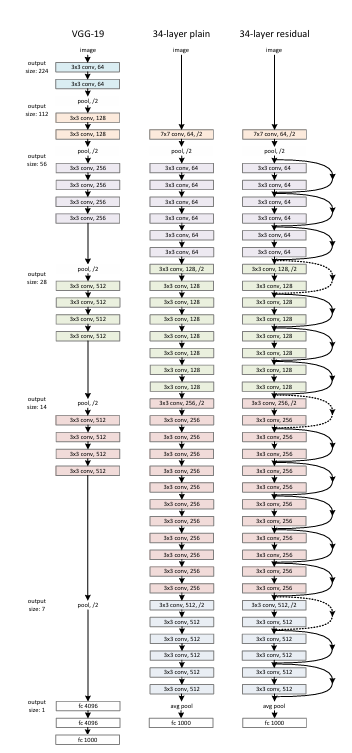

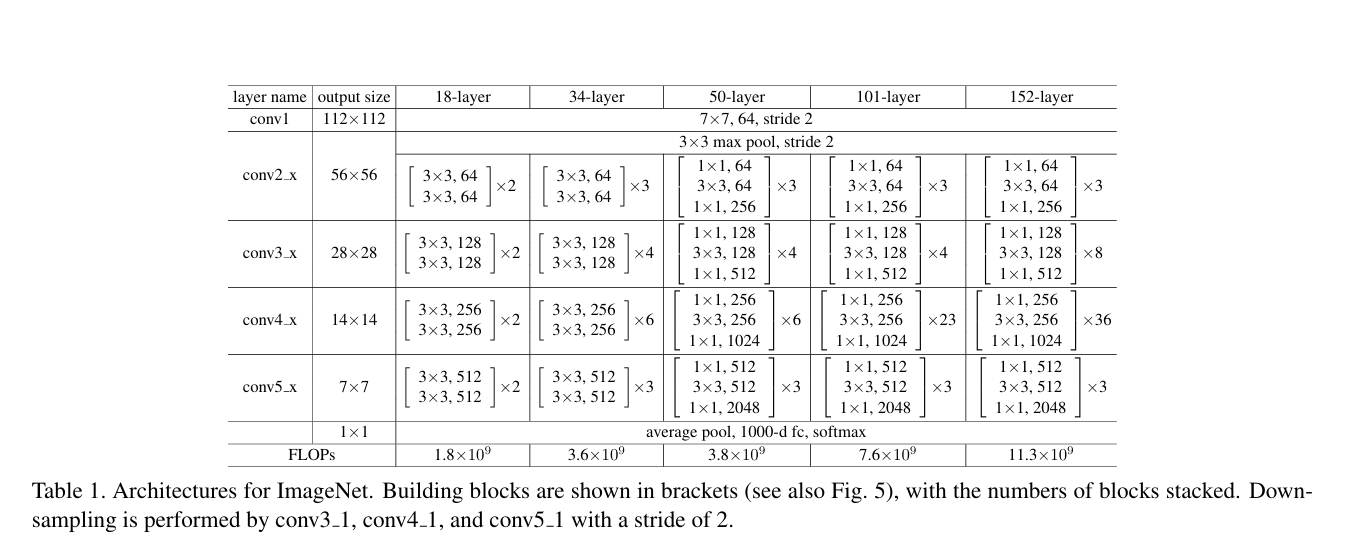

### TODO
1. Plain Networks.
    * PlainNet18
    * PlainNet34
    

2. Residual Networks.
    * Basic Block Networks: ResNet-18, ResNet-34
    * Bottleneck Networks: ResNet-50, ResNet-101, ResNet-152

3. Evaluation Metrics for Each Model:

    * Accuracy.
    * Confusion Matrix Visualization.
    * Recall.
    * Precision.
    * F1-Score.
    * ROC Curve & AUC Visualization.


4. Documentation Requirements:

    * Step-by-step explanation of the three architectures.
    * Inclusion of visual aids like graphs for better clarity.
    * References to the research papers for the model architectures.
    * A comparison of the models:
        * Results comparison.
        * Advantages and disadvantages of each architecture.
        * Analysis of why a specific architecture performs better for the given dataset and task.


In [3]:
import sys
import os
import shutil
import random
from datetime import datetime
from pathlib import Path
from dataclasses import dataclass, field
from typing import List, Optional, Union, Dict, Callable, Tuple
import logging
from collections import Counter
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as Fnn
import torchinfo
import torchvision
from torchvision.transforms import functional as Ftv
from torch.utils.data import DataLoader
from torchinfo import summary
from torchvision import datasets, transforms
import sklearn
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc,
    classification_report,
    precision_recall_curve,
)

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import early_stopping_pytorch
from early_stopping_pytorch import EarlyStopping


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
# Print versions of all relevant packages
print(f"Python version:", {sys.version})
print(f"PIL version: {Image.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"TorchVision version: {torchvision.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")
print(f"PyTorch EarlyStopping version: {early_stopping_pytorch.__version__}")

Python version: {'3.10.14 | packaged by conda-forge | (main, Mar 20 2024, 12:45:18) [GCC 12.3.0]'}
PIL version: 11.0.0
NumPy version: 1.26.4
PyTorch version: 2.4.0
TorchVision version: 0.19.0
Scikit-learn version: 1.2.2
Matplotlib version: 3.7.5
Seaborn version: 0.12.2
PyTorch EarlyStopping version: 1.0.10


In [6]:
### Helper funcitons

def count_layers(model: nn.Module) -> Tuple[int, int, int, int, int]:
    """
    Count the number of different layer types in a PyTorch model.

    Args:
        model (nn.Module): The PyTorch model to analyze.

    Returns:
        Tuple containing:
        - Number of convolutional layers
        - Number of batch normalization layers
        - Number of fully connected layers
        - Number of blocks (BasicBlock or Bottleneck)
        - Total number of layers
    """
    conv_layers = sum(1 for module in model.modules() if isinstance(module, nn.Conv2d))
    bn_layers = sum(1 for module in model.modules() if isinstance(module, nn.BatchNorm2d))
    fc_layers = sum(1 for module in model.modules() if isinstance(module, nn.Linear))
    block_count = sum(1 for module in model.modules() if isinstance(module, (BasicBlock, Bottleneck)))

    total_layers = conv_layers + bn_layers + fc_layers

    return conv_layers, bn_layers, fc_layers, block_count, total_layers

def set_seeds(seed: int = 42) -> None:
    """
    Set random seeds for reproducibility across PyTorch, NumPy, and Python's random module.

    Args:
        seed (int, optional): Random seed value. Defaults to 42.
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Function to count the number of images in each class for a given dataset
def count_images(dataset, class_names, dataset_name="Dataset"):
        labels = [label for _, label in dataset.samples]
        class_counts = dict(Counter(labels))
        print(f"Number of images per class in {dataset_name}:")
        for label, count in class_counts.items():
            class_name = class_names[label]
            print(f"  {class_name}: {count} images")
        return class_counts

# Function to visualize one random image per class before and after transformations
def visualize_one_image_per_class(dataset_raw, dataset_transformed, class_names):
    """
    Visualize one random image per class from the raw and transformed datasets.
    
    Args:
        dataset_raw: The raw dataset (without transformations).
        dataset_transformed: The transformed dataset (with applied transformations).
        class_names: A list of class names, e.g. ['Defective', 'OK']
    """
    fig, axes = plt.subplots(2, len(class_names), figsize=(15, 10))  
    
    for idx, class_name in enumerate(class_names):
        # Get the index corresponding to the class name
        class_idx = idx  
        
        # Get a random image from the raw dataset
        raw_class_samples = [img_path for img_path, label in dataset_raw.samples if label == class_idx]
        random_raw_img_path = random.choice(raw_class_samples)
        image_raw = Image.open(random_raw_img_path)
        
        # Get a random image from the transformed dataset
        transformed_class_samples = [img_path for img_path, label in dataset_transformed.samples if label == class_idx]
        random_transformed_img_path = random.choice(transformed_class_samples)
        image_transformed, _ = dataset_transformed[dataset_transformed.samples.index((random_transformed_img_path, class_idx))]
        
        # Convert transformed image to PIL for visualization
        image_transformed = Ftv.to_pil_image(image_transformed)  
        
        # Plot raw image
        ax_raw = axes[0, idx]
        ax_raw.imshow(image_raw)
        ax_raw.set_title(f'{class_name} (Raw)')
        ax_raw.axis('off')
        
        # Plot transformed image
        ax_transformed = axes[1, idx]
        ax_transformed.imshow(image_transformed)
        ax_transformed.set_title(f'{class_name} (Transformed)')
        ax_transformed.axis('off')
    
    plt.tight_layout()
    plt.show()


In [7]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None, is_plain=False):
        super(BasicBlock, self).__init__()

        self.is_plain = is_plain

        # Convolution layers
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Downsample (shortcut) connection
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # Plain network: no residual connection
        if self.is_plain:
            return self.relu(out)

        # Apply downsample (projection) if needed
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None, is_plain=False):
        super(Bottleneck, self).__init__()

        self.is_plain = is_plain

        # Bottleneck design: 1x1, 3x3, 1x1 convolutions
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        # Plain network: no residual connection
        if self.is_plain:
            return self.relu(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNetBase(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1000, is_plain=False):
        super(ResNetBase, self).__init__()
        self.in_channels = 64
        self.is_plain = is_plain

        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Create layers with increasing channels
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        # Global average pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layer
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        downsample = None

        # For plain networks, no residual connections
        if not self.is_plain:
            # If stride is not 1 or input channels differ from output channels
            if stride != 1 or self.in_channels != out_channels * block.expansion:
                # Option B: Projection shortcut
                downsample = nn.Sequential(
                    nn.Conv2d(self.in_channels, out_channels * block.expansion,
                              kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(out_channels * block.expansion)
                )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample, self.is_plain))

        # Update input channels for subsequent blocks
        self.in_channels = out_channels * block.expansion

        # Add remaining blocks
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels, 1, None, self.is_plain))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x



In [8]:
class ResNetModelFactory:
    """Factory for creating flexible ResNet models."""

    MODEL_CONFIGS: Dict[str, tuple] = {
        # Plain Networks
        'plainnet18': (BasicBlock, [2, 2, 2, 2], True),
        'plainnet34': (BasicBlock, [3, 4, 6, 3], True),
        # Residual Networks (Basic Blocks)
        'resnet18': (BasicBlock, [2, 2, 2, 2], False),
        'resnet34': (BasicBlock, [3, 4, 6, 3], False),
        # Residual Networks (Bottleneck)
        'resnet50': (Bottleneck, [3, 4, 6, 3], False),
        'resnet101': (Bottleneck, [3, 4, 23, 3], False),
        'resnet152': (Bottleneck, [3, 8, 36, 3], False)
    }

    @classmethod
    def create_model(
        cls,
        model_type: str = 'resnet18',
        num_classes: int = 2,
        is_plain: Optional[bool] = None,
        custom_fc: Optional[nn.Module] = None,
        device: Optional[torch.device] = None
    ) -> nn.Module:
        """
        Create a flexible ResNet for binary/multi-class classification.

        Args:
            model_type (str): Type of ResNet model
            num_classes (int): Number of output classes
            is_plain (bool, optional): Use plain network without residual connections
            custom_fc (nn.Module, optional): Custom final fully connected layer
            device (torch.device, optional): Device to move model to

        Returns:
            nn.Module: Configured ResNet model
        """
        model_type = model_type.lower()
        if model_type not in cls.MODEL_CONFIGS:
            supported_models = ', '.join(cls.MODEL_CONFIGS.keys())
            raise ValueError(f"Unsupported model type. Supported models: {supported_models}")

        block, num_blocks, is_plain_default = cls.MODEL_CONFIGS[model_type]
        is_plain = is_plain_default if is_plain is None else is_plain

        model = ResNetBase(block, num_blocks, num_classes=num_classes, is_plain=is_plain)

        # Configure final layer
        model.fc = (
            custom_fc or
            nn.Linear(model.fc.in_features, num_classes)
        )


        return model.to(device) if device else model



In [9]:
# Test input
test_input = torch.randn(1, 3, 224, 224).to(device)

# Plain Networks
plain_18 = ResNetModelFactory.create_model(
    model_type='plainnet18', 
    num_classes=2,  # Binary classification
    device=device
)
plain_34 = ResNetModelFactory.create_model(
    model_type='plainnet34', 
    num_classes=2,  # Binary classification
    device=device
)

# Residual Networks
res_18 = ResNetModelFactory.create_model(
    model_type='resnet18', 
    num_classes=2,  # Binary classification
    device=device
)
res_34 = ResNetModelFactory.create_model(
    model_type='resnet34', 
    num_classes=2,  # Binary classification
    device=device
)
res_50 = ResNetModelFactory.create_model(
    model_type='resnet50', 
    num_classes=2,  # Binary classification
    device=device
)
res_101 = ResNetModelFactory.create_model(
    model_type='resnet101', 
    num_classes=2,  # Binary classification
    device=device
)
res_152 = ResNetModelFactory.create_model(
    model_type='resnet152', 
    num_classes=2,  # Binary classification
    device=device
)

# Print number of layers in each model
models = {
    "PlainNet-18": plain_18,
    "PlainNet-34": plain_34,
    "ResNet-18": res_18,
    "ResNet-34": res_34,
    "ResNet-50": res_50,
    "ResNet-101": res_101,
    "ResNet-152": res_152
}

for name, model in models.items():
    conv, bn, fc, blocks, total = count_layers(model)
    output = model(test_input)
    print(f"{name}:")
    print(f"\tConv2d layers: {conv}")
    print(f"\tBatchNorm2d layers: {bn}")
    print(f"\tLinear layers: {fc}")
    print(f"\tBlocks: {blocks}")
    print(f"\tTotal layers: {total}")
    print("----------------------")

PlainNet-18:
	Conv2d layers: 17
	BatchNorm2d layers: 17
	Linear layers: 1
	Blocks: 8
	Total layers: 35
----------------------
PlainNet-34:
	Conv2d layers: 33
	BatchNorm2d layers: 33
	Linear layers: 1
	Blocks: 16
	Total layers: 67
----------------------
ResNet-18:
	Conv2d layers: 20
	BatchNorm2d layers: 20
	Linear layers: 1
	Blocks: 8
	Total layers: 41
----------------------
ResNet-34:
	Conv2d layers: 36
	BatchNorm2d layers: 36
	Linear layers: 1
	Blocks: 16
	Total layers: 73
----------------------
ResNet-50:
	Conv2d layers: 53
	BatchNorm2d layers: 53
	Linear layers: 1
	Blocks: 16
	Total layers: 107
----------------------
ResNet-101:
	Conv2d layers: 104
	BatchNorm2d layers: 104
	Linear layers: 1
	Blocks: 33
	Total layers: 209
----------------------
ResNet-152:
	Conv2d layers: 155
	BatchNorm2d layers: 155
	Linear layers: 1
	Blocks: 50
	Total layers: 311
----------------------


In [10]:
# Get a summary of the model
summary(res_50,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "kernel_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Kernel Shape         Output Shape         Param #              Trainable
ResNetBase (ResNetBase)                  [32, 3, 224, 224]    --                   [32, 2]              --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [7, 7]               [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   --                   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   --                   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   3                    [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     --                   [32, 256, 56, 56]    --                   True
│    └─Bottleneck (0)                    [32, 64, 56, 56]     --                   [32, 2

In [11]:
class CastingDefectEvaluator:
    def __init__(self, model, test_loader, device, class_names, model_name):
        """
        Initialize evaluator for comprehensive model performance analysis
        
        Args:
            model (nn.Module): Trained neural network model
            test_loader (DataLoader): DataLoader for test dataset
            device (torch.device): Computing device
            class_names (list): List of class names, e.g., ['Defective', 'OK']
            model_name (str): Name of the model for labeling plots
        """
        self.model = model
        self.test_loader = test_loader
        self.device = device
        self.class_names = class_names
        self.model_name = model_name
        
        # Create plots directory
        self.plots_dir = 'plots'
        os.makedirs(self.plots_dir, exist_ok=True)
        
        # Prepare for metric collection
        self.true_labels = []
        self.predicted_labels = []
        self.predicted_probs = []

    def collect_predictions(self):
        """
        Collect model predictions and true labels
        
        Returns:
            tuple: Arrays of true labels, predicted labels, and predicted probabilities
        """
        self.model.eval()
        self.true_labels = []
        self.predicted_labels = []
        self.predicted_probs = []
        
        with torch.no_grad():
            for inputs, labels in self.test_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                
                outputs = self.model(inputs)
                probs = torch.softmax(outputs, dim=1)
                
                self.true_labels.extend(labels.cpu().numpy())
                self.predicted_labels.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                self.predicted_probs.extend(probs[:, 1].cpu().numpy())
        
        return (
            np.array(self.true_labels), 
            np.array(self.predicted_labels), 
            np.array(self.predicted_probs)
        )
    
    def calculate_metrics(self):
        """
        Calculate comprehensive evaluation metrics
        
        Returns:
            dict: Dictionary of calculated metrics
        """
        true_labels, pred_labels, pred_probs = self.collect_predictions()
        
        # Classification Report
        report = classification_report(
            true_labels, 
            pred_labels, 
            target_names=self.class_names,  
            output_dict=True
        )
        
        # Confusion Matrix
        cm = confusion_matrix(true_labels, pred_labels)
        
        # ROC Curve and AUC
        fpr, tpr, _ = roc_curve(true_labels, pred_probs)
        roc_auc = auc(fpr, tpr)
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(true_labels, pred_probs)
        pr_auc = auc(recall, precision)
        
        return {
            'classification_report': report,
            'confusion_matrix': cm,
            'roc_auc': roc_auc,
            'pr_auc': pr_auc,
            'fpr': fpr,
            'tpr': tpr,
            'precision': precision,
            'recall': recall,
            'true_labels': true_labels,
            'pred_labels': pred_labels,
            'pred_probs': pred_probs
        }
    
    def visualize_metrics(self, metrics):
        """
        Create comprehensive visualizations of model performance metrics
        
        Args:
            metrics (dict): Calculated metrics
        """
        plt.figure(figsize=(20, 15))
        plt.suptitle(f'Model Performance Metrics: {self.model_name}', fontsize=16)

        # 1. Confusion Matrix
        plt.subplot(2, 2, 1)
        sns.heatmap(
            metrics['confusion_matrix'], 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=self.class_names,  
            yticklabels=self.class_names  
        )
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')

        # 2. ROC Curve
        plt.subplot(2, 2, 2)
        plt.plot(
            metrics['fpr'], 
            metrics['tpr'], 
            color='darkorange',
            lw=2, 
            label=f'ROC curve (AUC = {metrics["roc_auc"]:.2f})'
        )
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")

        # 3. Precision-Recall Curve
        plt.subplot(2, 2, 3)
        plt.step(
            metrics['recall'], 
            metrics['precision'], 
            color='b', 
            alpha=0.2,
            where='post'
        )
        plt.fill_between(
            metrics['recall'], 
            metrics['precision'], 
            step='post', 
            alpha=0.2, 
            color='b'
        )
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve (AUC = {metrics["pr_auc"]:.2f})')

        # 4. Class-wise Performance Metrics
        plt.subplot(2, 2, 4)
        report = metrics['classification_report']
        class_metrics = []
        for class_name in self.class_names:
            class_metrics.append([
                report[class_name]['precision'],
                report[class_name]['recall'],
                report[class_name]['f1-score']
            ])
        
        class_metrics = np.array(class_metrics)
        x = np.arange(len(self.class_names))
        width = 0.25
        
        plt.bar(x - width, class_metrics[:, 0], width, label='Precision')
        plt.bar(x, class_metrics[:, 1], width, label='Recall')
        plt.bar(x + width, class_metrics[:, 2], width, label='F1-Score')
        
        plt.xlabel('Classes')
        plt.ylabel('Score')
        plt.title('Class-wise Performance Metrics')
        plt.xticks(x, self.class_names)
        plt.legend()

        # Save the plot
        plot_path = os.path.join(self.plots_dir, f'{self.model_name}_performance_metrics.png')
        plt.tight_layout()
        plt.savefig(plot_path)
        plt.close()

        print(f"\n--- Comprehensive Evaluation Metrics ---")
        print(classification_report(
            metrics['true_labels'], 
            metrics['pred_labels'], 
            target_names=self.class_names  
        ))
        
        print(f"\nROC AUC: {metrics['roc_auc']:.4f}")
        print(f"Precision-Recall AUC: {metrics['pr_auc']:.4f}")
        
        print(f"\nPerformance metrics plot saved to {plot_path}")

In [12]:
class CastingDataLoader:
    def __init__(self, data_dir, batch_size=32):
        """
        Initializes the data loaders for casting defect classification.

        Args:
            data_dir (str): Path to directory containing train and test folders.
            batch_size (int): Batch size for training and validation.
        """
        self.data_dir = data_dir
        self.batch_size = batch_size

        # Define common data transformations
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # Resize to ResNet input size
            transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3-channel
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale input
        ])

        # Define class mappings (numeric index to class name)
        self.class_mapping = {
            0: 'Defective',  # 'def_front'
            1: 'OK'          # 'ok_front'
        }

    def get_loaders(self):
        """
        Prepares and returns the training and testing data loaders.

        Returns:
            tuple: (train_loader, test_loader)
        """
        # Load training dataset
        train_dataset = datasets.ImageFolder(
            os.path.join(self.data_dir, 'train'), transform=self.transform
        )
        # Load testing dataset
        test_dataset = datasets.ImageFolder(
            os.path.join(self.data_dir, 'test'), transform=self.transform
        )

        # Data loaders
        train_loader = DataLoader(
            train_dataset, batch_size=self.batch_size, shuffle=True
        )
        test_loader = DataLoader(
            test_dataset, batch_size=self.batch_size, shuffle=False
        )

        return train_loader, test_loader

    def get_class_names(self):
        return list(self.class_mapping.values())


In [20]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from early_stopping_pytorch import EarlyStopping

class CastingDefectTrainer:
    def __init__(self, 
                 train_loader, 
                 test_loader, 
                 model_type='resnet18', 
                 num_epochs=50, 
                 learning_rate=0.001,
                 device=None,
                 patience=10,
                 class_names=None
                ):
        """
        Trainer for casting defect classification.
        
        Args:
            train_loader (DataLoader): Training data loader
            test_loader (DataLoader): Testing data loader
            model_type (str): Type of model to use (default: 'resnet18')
            num_epochs (int): Number of training epochs
            learning_rate (float): Learning rate for optimizer
            device (torch.device, optional): Computing device
            patience (int): Patience for early stopping
            class_names (list, optional): Names of classes
        """
        # Device configuration
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Data loaders
        self.train_loader = train_loader
        self.test_loader = test_loader

        # Model initialization
        self.model_type = model_type
        self.model = ResNetModelFactory.create_model(
            model_type=self.model_type, num_classes=2, device=self.device
        )

        # Loss and optimizer
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=1e-4)

        # Training parameters
        self.num_epochs = num_epochs
        
        # Create plots directory
        self.plots_dir = 'plots'
        os.makedirs(self.plots_dir, exist_ok=True)

        # Ensure models directory exists
        if not os.path.exists('models'):
            os.makedirs('models')

        # Model saving path
        self.best_model_path = os.path.join('models', f'casting_defect_{self.model_type}_best_model.pth')  

        # Early stopping
        self.early_stopping = EarlyStopping(patience=patience, verbose=True, path=self.best_model_path)

        # Set class names
        self.class_names = class_names or ['Defective', 'Ok']

        # Best metrics tracking
        self.best_metrics = {
            'train': {
                'loss': float('inf'),
                'accuracy': 0.0
            },
            'test': {
                'loss': float('inf'),
                'accuracy': 0.0
            }
        }

    def train(self):
        """
        Train the model with comprehensive tracking and visualization.
        
        Returns:
            tuple: Best metrics and training history
        """
        # Tracking full training history
        training_history = {
            'train_loss': [],
            'test_loss': [],
            'train_accuracy': [],
            'test_accuracy': []
        }

        print(f"Training on {self.device}")
        
        for epoch in range(self.num_epochs):
            print(f'\nEpoch [{epoch+1}/{self.num_epochs}]')
        
            # Training Phase
            self.model.train()
            train_loss, train_correct, train_total = 0, 0, 0
        
            for inputs, labels in self.train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
        
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
        
                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()
        
            train_loss /= len(self.train_loader)
            train_accuracy = 100 * train_correct / train_total
        
            # Validation Phase
            self.model.eval()
            test_loss, test_correct, test_total = 0, 0, 0
        
            with torch.no_grad():
                for inputs, labels in self.test_loader:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
        
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, labels)
        
                    test_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    test_total += labels.size(0)
                    test_correct += (predicted == labels).sum().item()
        
            test_loss /= len(self.test_loader)
            test_accuracy = 100 * test_correct / test_total
        
            # Update best metrics and save the best model
            if test_loss < self.best_metrics['test']['loss']:
                self.best_metrics['test']['loss'] = test_loss
                self.best_metrics['test']['accuracy'] = test_accuracy
                # Save the best model during training
                torch.save(self.model.state_dict(), self.best_model_path)

            # Update best metrics for training
            if train_loss < self.best_metrics['train']['loss']:
                self.best_metrics['train']['loss'] = train_loss
                self.best_metrics['train']['accuracy'] = train_accuracy
        
            # Store training history
            training_history['train_loss'].append(train_loss)
            training_history['test_loss'].append(test_loss)
            training_history['train_accuracy'].append(train_accuracy)
            training_history['test_accuracy'].append(test_accuracy)
        
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%")
            print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")
        
            # Early Stopping
            self.early_stopping(test_loss, self.model)
        
            if self.early_stopping.early_stop:
                print("Early stopping triggered!")
                break
        
        # Visualization of Training Metrics
        self._visualize_training_metrics(training_history)
        
        # Load the best model
        self.model.load_state_dict(torch.load(self.best_model_path, weights_only=True))
        
        # Print best metrics
        print("\n--- Best Training and Testing Metrics ---")
        print("Training:")
        print(f"Best Loss: {self.best_metrics['train']['loss']:.4f}")
        print(f"Best Accuracy: {self.best_metrics['train']['accuracy']:.2f}%")
        print("\nTesting:")
        print(f"Best Loss: {self.best_metrics['test']['loss']:.4f}")
        print(f"Best Accuracy: {self.best_metrics['test']['accuracy']:.2f}%")
        print(f"\nBest model saved to {self.best_model_path}")
        
        return self.best_metrics, training_history

    def _visualize_training_metrics(self, training_history):
        """
        Create comprehensive visualizations of training metrics
        
        Args:
            training_history (dict): Dictionary containing training metrics
        """
        plt.figure(figsize=(15, 10))
        plt.suptitle(f'Training Metrics for {self.model_type}', fontsize=16)

        # Loss Plot
        plt.subplot(2, 2, 1)
        plt.plot(training_history['train_loss'], label='Train Loss')
        plt.plot(training_history['test_loss'], label='Test Loss')
        plt.title('Loss Curves')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Accuracy Plot
        plt.subplot(2, 2, 2)
        plt.plot(training_history['train_accuracy'], label='Train Accuracy')
        plt.plot(training_history['test_accuracy'], label='Test Accuracy')
        plt.title('Accuracy Curves')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()

        # Save the plot
        plot_path = os.path.join(self.plots_dir, f'{self.model_type}_training_metrics.png')
        plt.tight_layout()
        plt.savefig(plot_path)
        plt.close()

        print(f"Training metrics plot saved to {plot_path}")

    def evaluate_model(self):
        """
        Comprehensive model evaluation
        
        Returns:
            dict: Evaluation metrics
        """
        # Load the best model for evaluation
        self.model.load_state_dict(torch.load(self.best_model_path, weights_only=True))
    
        evaluator = CastingDefectEvaluator(
            self.model, 
            self.test_loader, 
            self.device,
            self.class_names,
            self.model_type
        )
        
        metrics = evaluator.calculate_metrics()
        evaluator.visualize_metrics(metrics)
        
        return metrics


    def save_model_summary_markdown(self, input_size=(32, 3, 224, 224)):
        """
        Save the model summary as a Markdown file
        
        Args:
            input_size (tuple): Input size for summary calculation
        """
        from torchinfo import summary
        import os
        
        # Ensure the directory exists
        summaries_dir = 'summaries'
        os.makedirs(summaries_dir, exist_ok=True)
        
        # Generate summary
        summary_text = str(summary(
            self.model,
            input_size=input_size,
            verbose=0,
            col_names=["input_size", "kernel_size", "output_size", "num_params", "trainable"],
            col_width=20,
            row_settings=["var_names"]
        ))
        
        # Save to a markdown file
        file_path = os.path.join(summaries_dir, f'{self.model_type}_model_summary.md')
        with open(file_path, 'w') as f:
            f.write(f"# {self.model_type} Model Summary\n\n```\n{summary_text}\n```")
        
        print(f"Model summary saved to {file_path}")


In [14]:
# Configuration
DATA_DIR = '/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data'
MODEL_TYPE = 'resnet50'

# Initialize data loader
data_loader = CastingDataLoader(data_dir=DATA_DIR, batch_size=32)
train_loader, test_loader = data_loader.get_loaders()

In [15]:
# Check shapes of train_loader and test_loader
train_inputs, train_labels = next(iter(train_loader))
test_inputs, test_labels = next(iter(test_loader))

print(f"Train Loader:")
print(f"Input batch shape: {train_inputs.shape}")
print(f"Label batch shape: {train_labels.shape}")

print(f"\nTest Loader:")
print(f"Input batch shape: {test_inputs.shape}")
print(f"Label batch shape: {test_labels.shape}")


Train Loader:
Input batch shape: torch.Size([32, 3, 224, 224])
Label batch shape: torch.Size([32])

Test Loader:
Input batch shape: torch.Size([32, 3, 224, 224])
Label batch shape: torch.Size([32])


In [16]:
# Get the raw datasets from the loaders (for visualization and counting)
train_dataset = datasets.ImageFolder(
    os.path.join('/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data', 'train'), transform=None  # No transformation for raw images
)
test_dataset = datasets.ImageFolder(
    os.path.join('/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data', 'test'), transform=None  # No transformation for raw images
)



In [17]:
class_names = data_loader.get_class_names()
class_names

['Defective', 'OK']

Number of images per class in Training Dataset:
  Defective: 3758 images
  OK: 2875 images
Number of images per class in Testing Dataset:
  Defective: 453 images
  OK: 262 images


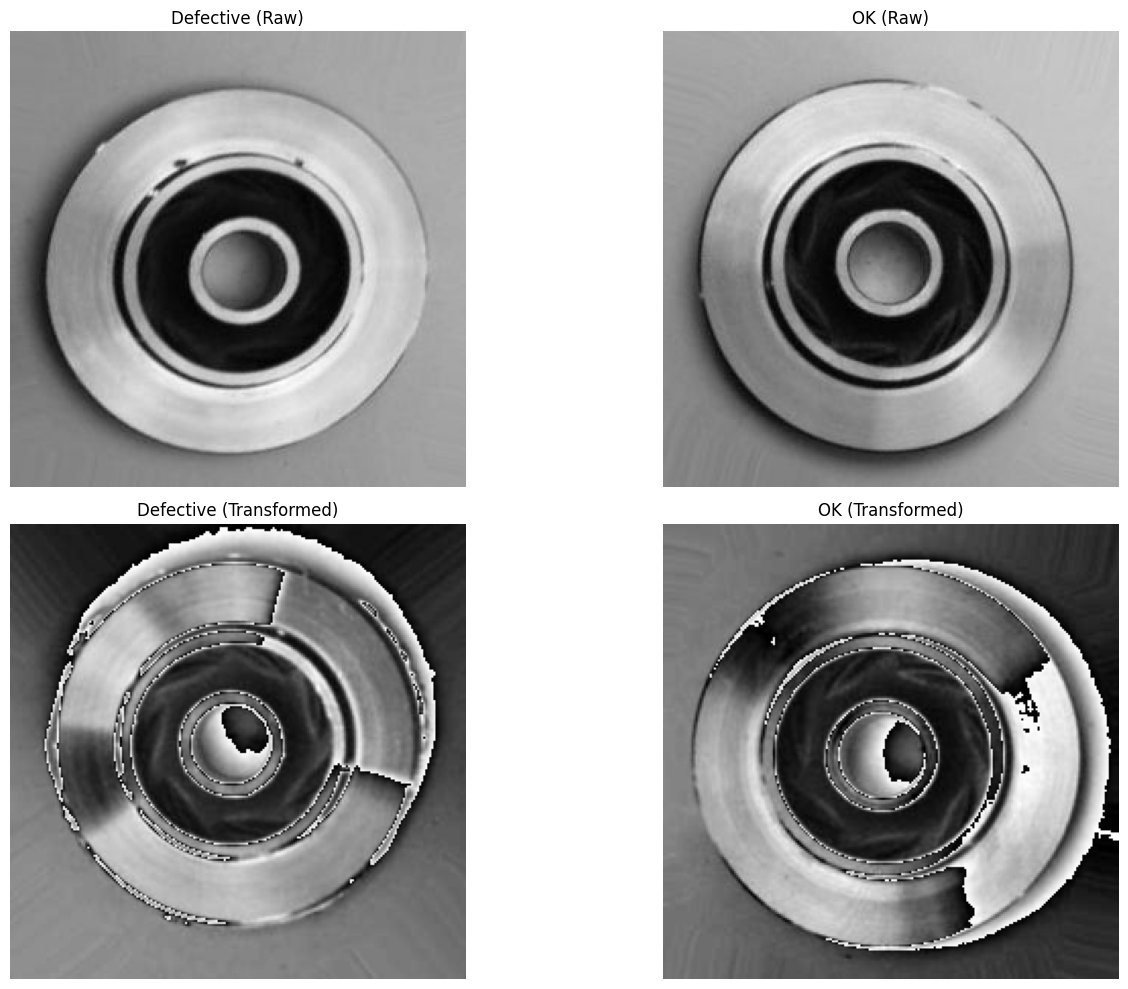

In [18]:
# Count images per class for training dataset
count_images(train_dataset, class_names, "Training Dataset")

# Count images per class for testing dataset
count_images(test_dataset, class_names, "Testing Dataset")

# Visualize one image per class from the raw and transformed datasets
visualize_one_image_per_class(train_dataset, train_loader.dataset, class_names)

### Train ResNet50

In [22]:
set_seeds(seed=42)

trainer = CastingDefectTrainer(
    train_loader, 
    test_loader, 
    model_type='resnet50',
    num_epochs=3,
    learning_rate=0.0001,
    patience=1,
    class_names=class_names
)
# Train the model
best_metrics, training_history = trainer.train()

# Save model summary image
trainer.save_model_summary_markdown(train_inputs.shape)

# Evaluate the model
metrics = trainer.evaluate_model()

Training on cuda

Epoch [1/3]
Train Loss: 0.2288, Train Acc: 90.08%
Test Loss: 0.0973, Test Acc: 96.78%
Validation loss decreased (inf --> 0.097287).  Saving model ...

Epoch [2/3]
Train Loss: 0.0622, Train Acc: 97.78%
Test Loss: 0.0273, Test Acc: 99.02%
Validation loss decreased (0.097287 --> 0.027322).  Saving model ...

Epoch [3/3]
Train Loss: 0.0436, Train Acc: 98.73%
Test Loss: 0.1204, Test Acc: 94.55%
EarlyStopping counter: 1 out of 1
Early stopping triggered!
Training metrics plot saved to plots/resnet50_training_metrics.png

--- Best Training and Testing Metrics ---
Training:
Best Loss: 0.0436
Best Accuracy: 98.73%

Testing:
Best Loss: 0.0273
Best Accuracy: 99.02%

Best model saved to models/casting_defect_resnet50_best_model.pth
Model summary saved to summaries/resnet50_model_summary.md

--- Comprehensive Evaluation Metrics ---
              precision    recall  f1-score   support

   Defective       0.99      1.00      0.99       453
          OK       1.00      0.98      0.9

### Train all ResNet varaints

In [23]:
# Define model types
MODEL_TYPES = ['plainnet18', 'plainnet34', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152']

num_epochs = 50

# Initialize storage for best metrics
all_best_metrics = {}

# Train each model variant
for model_type in MODEL_TYPES:
    print(f"\n--- Training model: {model_type} ---")
    try:
        # Initialize the trainer for the current model type
        trainer = CastingDefectTrainer(
            train_loader=train_loader,
            test_loader=test_loader,
            model_type=model_type,
            num_epochs=num_epochs,
            learning_rate=0.0001,
            patience=10,
            class_names=class_names
        )

        # Train the model and store the best metrics
        best_metrics, training_history = trainer.train()
        all_best_metrics[model_type] = best_metrics

        # Save model summary
        trainer.save_model_summary_markdown(input_size=train_inputs.shape)

        # Evaluate the best model and log additional metrics
        metrics = trainer.evaluate_model()

        # Optionally store detailed metrics for further analysis
        all_best_metrics[model_type].update(metrics)
    except Exception as e:
        print(f"Error occurred while training model {model_type}: {e}")

# Summary of all model metrics
print("\n--- Best Metrics for All Models ---")
for model_type, metrics in all_best_metrics.items():
    print(f"\nModel: {model_type}")
    print(f"Best Train Loss: {metrics['train']['loss']:.4f}")
    print(f"Best Train Accuracy: {metrics['train']['accuracy']:.2f}%")
    print(f"Best Test Loss: {metrics['test']['loss']:.4f}")
    print(f"Best Test Accuracy: {metrics['test']['accuracy']:.2f}%")



--- Training model: plainnet18 ---
Training on cuda

Epoch [1/50]
Train Loss: 0.1864, Train Acc: 92.33%
Test Loss: 0.1880, Test Acc: 93.43%
Validation loss decreased (inf --> 0.188016).  Saving model ...

Epoch [2/50]
Train Loss: 0.0547, Train Acc: 98.24%
Test Loss: 0.2888, Test Acc: 89.37%
EarlyStopping counter: 1 out of 10

Epoch [3/50]
Train Loss: 0.0479, Train Acc: 98.55%
Test Loss: 0.0219, Test Acc: 99.58%
Validation loss decreased (0.188016 --> 0.021894).  Saving model ...

Epoch [4/50]
Train Loss: 0.0304, Train Acc: 99.02%
Test Loss: 0.0494, Test Acc: 98.32%
EarlyStopping counter: 1 out of 10

Epoch [5/50]
Train Loss: 0.0214, Train Acc: 99.43%
Test Loss: 1.2265, Test Acc: 66.15%
EarlyStopping counter: 2 out of 10

Epoch [6/50]
Train Loss: 0.0375, Train Acc: 98.73%
Test Loss: 0.9563, Test Acc: 73.43%
EarlyStopping counter: 3 out of 10

Epoch [7/50]
Train Loss: 0.0354, Train Acc: 98.75%
Test Loss: 0.0062, Test Acc: 99.86%
Validation loss decreased (0.021894 --> 0.006208).  Saving

### Inference

In [32]:
class CastingDefectInference:
    def __init__(self, model_paths, model_type='resnet18', device=None):
        """
        Initialize inference class for casting defect models
        
        Args:
            model_paths (list): List of paths to the saved model weights
            model_type (str, optional): Type of ResNet model used
            device (torch.device, optional): Computing device
        """
        # Set device (GPU if available, else CPU)
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Class mapping
        self.class_mapping = {
            0: 'Defective',
            1: 'OK'
        }
        
        # Preprocessing transforms
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])
        
        # Load the models
        self.models = []
        for model_path in model_paths:
            model = ResNetModelFactory.create_model(
                model_type=model_type, 
                num_classes=2, 
                device=self.device
            )
            model.load_state_dict(torch.load(model_path, map_location=self.device, weights_only=True))
            model.eval()
            self.models.append(model)
    
    def preprocess_image(self, image_path):
        """
        Preprocess an image for model inference
        
        Args:
            image_path (str): Path to the image file
        
        Returns:
            torch.Tensor: Preprocessed image tensor
        """
        image = Image.open(image_path)
        return self.transform(image).unsqueeze(0)
    
    def predict_with_all_models(self, image_path, top_k=2):
        """
        Perform prediction on a single image with all saved models
        
        Args:
            image_path (str): Path to the image file
            top_k (int, optional): Number of top predictions to return
        
        Returns:
            dict: Prediction results for all models with class, probability, and confidence
        """
        # Preprocess the image
        input_tensor = self.preprocess_image(image_path).to(self.device)
        
        all_model_results = []
        
        # Iterate through each model and perform inference
        for model in self.models:
            with torch.no_grad():
                outputs = model(input_tensor)
                probabilities = torch.softmax(outputs, dim=1)
                top_prob, top_class = torch.topk(probabilities, top_k)
            
            # Convert to numpy for easier processing
            top_prob = top_prob.cpu().numpy()[0]
            top_class = top_class.cpu().numpy()[0]
            
            # Prepare results for each model
            model_results = []
            for prob, cls in zip(top_prob, top_class):
                model_results.append({
                    'class': self.class_mapping[cls],
                    'probability': float(prob),
                    'confidence_percentage': float(prob * 100)
                })
            
            all_model_results.append(model_results)
        
        return all_model_results



In [33]:
def main():
    MODEL_TYPES = ['plainnet18', 'plainnet34', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152']
    saved_models_dir = '/kaggle/working/models'
    
    # Single image path
    single_image_path = '/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_512x512/casting_512x512/def_front/cast_def_0_1055.jpeg'
    
    for model_type in MODEL_TYPES:
        model_path = f"{saved_models_dir}/casting_defect_{model_type}_best_model.pth"
        
        # Initialize inference engine for each model type
        inference_engine = CastingDefectInference(
            model_paths=[model_path], 
            model_type=model_type
        )
        
        # Predict single image
        single_prediction = inference_engine.predict_with_all_models(single_image_path)
        print(f"Single Image Prediction for {model_type}:")
        for model_results in single_prediction:
            for result in model_results:
                print(f"Class: {result['class']}")
                print(f"Probability: {result['probability']:.4f}")
                print(f"Confidence: {result['confidence_percentage']:.2f}%")
        print("\n")

if __name__ == "__main__":
    main()



Single Image Prediction for plainnet18:
Class: Defective
Probability: 0.9961
Confidence: 99.61%
Class: OK
Probability: 0.0039
Confidence: 0.39%


Single Image Prediction for plainnet34:
Class: Defective
Probability: 1.0000
Confidence: 100.00%
Class: OK
Probability: 0.0000
Confidence: 0.00%


Single Image Prediction for resnet18:
Class: Defective
Probability: 0.9999
Confidence: 99.99%
Class: OK
Probability: 0.0001
Confidence: 0.01%


Single Image Prediction for resnet34:
Class: Defective
Probability: 1.0000
Confidence: 100.00%
Class: OK
Probability: 0.0000
Confidence: 0.00%


Single Image Prediction for resnet50:
Class: Defective
Probability: 0.9997
Confidence: 99.97%
Class: OK
Probability: 0.0003
Confidence: 0.03%


Single Image Prediction for resnet101:
Class: Defective
Probability: 1.0000
Confidence: 100.00%
Class: OK
Probability: 0.0000
Confidence: 0.00%


Single Image Prediction for resnet152:
Class: Defective
Probability: 0.9999
Confidence: 99.99%
Class: OK
Probability: 0.0001
Con